In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import pre_filter_items
from src.recommenders import MainRecommender

In [352]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = pre_filter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, 5)

[1044078, 899624, 1106523, 871756, 844179]

In [6]:
recommender.get_own_recommendations(2375, 5)

[1029743, 1106523, 5569230, 916122, 844179]

In [7]:
recommender.get_similar_items_recommendation(2375, 5)

[1046545, 1044078, 1044078, 10355376, 1018809]

In [8]:
recommender.get_similar_users_recommendation(2375, 5)

[1029743, 1106523, 5569230, 916122, 844179]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  




In [9]:
train_users = data_train_lvl_1['user_id'].unique() # warm start

result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.loc[result_lvl_1.user_id.isin(train_users)]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['own_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 50))

In [11]:
result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_candidates'], row['actual'], k=50), axis=1)

In [12]:
result_lvl_1['own_recall'].mean()

0.04323684353105271

In [13]:
result_lvl_1['als_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

In [14]:
result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_candidates'], row['actual'], k=50), axis=1)

In [15]:
result_lvl_1['als_recall'].mean()

0.04924746543811566

In [16]:
result_lvl_1['sim_item_candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, 50))

In [17]:
result_lvl_1['sim_item_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['sim_item_candidates'], row['actual'], k=50), axis=1)

In [18]:
result_lvl_1['sim_item_recall'].mean()

0.033866940689723075

В итоге получаем, что на 50 кандидатах лучший результат дает ALS. 

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [20]:
def get_candidates_recall(df, model, k):
    df = df.copy(deep=True)
    df['candidates_col'] = df['user_id'].apply(lambda x: model(x, k))
    df['recall_col'] = df.apply(lambda row: recall_at_k(row['candidates_col'], row['actual'], k=k), axis=1)
    return df['recall_col'].mean()

In [44]:
def eval_models(df, models, ks, model_names=None):
    results = {}
    model_num = 0
    for model in models:
        model_num += 1
        results[f'model_{model_num}'] = {}
        for k in ks:
            results[f'model_{model_num}'][k] = get_candidates_recall(df=df, model=model, k=k)
    df = pd.DataFrame.from_dict(results)
    if model_names:
        cols = df.columns
        df.rename(columns=dict(zip(cols, model_names)), inplace=True)
    return df      

In [49]:
%%time
ks_to_eval = [20, 50, 100, 200, 500]
models_to_eval = [recommender.get_own_recommendations,
                  recommender.get_als_recommendations,
                  recommender.get_similar_items_recommendation]

model_names = ['own', 'als', 'sim_items']

hist = eval_models(result_lvl_1, models_to_eval, ks_to_eval, model_names)

CPU times: user 9min 23s, sys: 9min 24s, total: 18min 47s
Wall time: 3min 1s


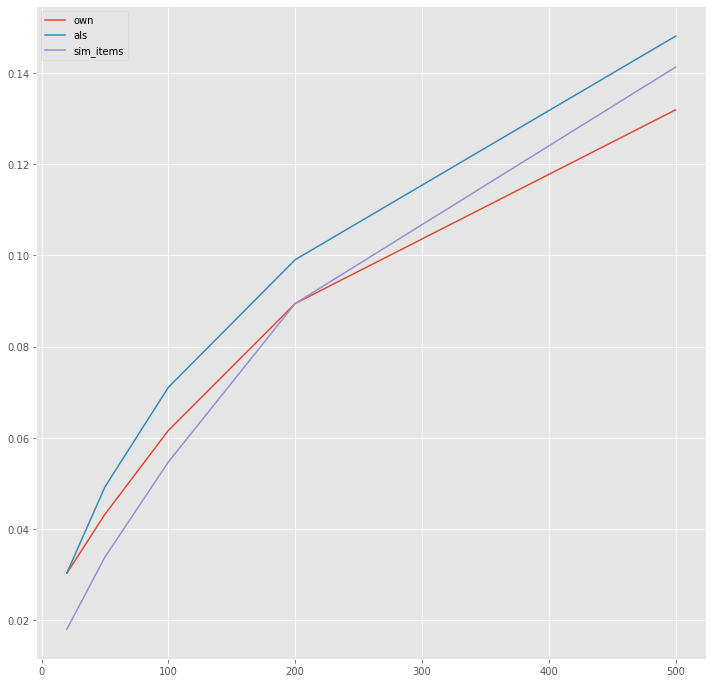

In [71]:
hist.plot(figsize=(12, 12))

Видим, что recall растет вместе с k.

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Я думаю, что если есть ограничение по вычислительным мощностям, то можно остановиться на k равном 200, потому что на графике видно, что на этом месте интенсивность роста recall при увеличении k уменьшается. Можно даже предположить, что дальнейший рост уже не зависит от модели, т.к. линии, кажется, становятся паралелльными, т.е. разница только в изначальном преимуществе одной из моделей.

### Задание 2

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

Точность модели ALS

In [111]:
result_lvl_1['als_precision'] = result_lvl_1.apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=50), axis=1)

In [209]:
als_candidates = result_lvl_1[['user_id', 'als_candidates']]

In [237]:
als_candidates.head() # кандидаты модели первого уровня

,user_id,als_candidates
0,1,"[1094924, 1037332, 885290, 841584, 955587, 697..."
1,2,"[10150194, 1001277, 5569230, 951197, 929410, 9..."
2,4,"[987044, 982790, 891423, 6391541, 1137346, 846..."
3,6,"[863632, 1026118, 965267, 951834, 1084036, 878..."
4,7,"[10285022, 1039627, 1041688, 1006483, 8276172,..."


In [221]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

In [222]:
valid_lvl_2 = valid_lvl_2.merge(als_candidates, on='user_id', how='left')

### Посчитаем точность ALS на валидационном датасете

In [236]:
valid_lvl_2[valid_lvl_2.als_candidates.notna()].\
apply(lambda row: precision_at_k(row['als_candidates'], row['actual'], k=5), axis=1).mean()

0.09879895561357663

In [102]:
users_lvl_2 = pd.DataFrame(result_lvl_1['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

In [103]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [104]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.tail(4)

,user_id,item_id,flag
2150,2500,1126899,1
2150,2500,8180870,1
2150,2500,922651,1
2150,2500,1113274,1


In [106]:
data_train_lvl_2 = data_val_lvl_1.copy()

In [107]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [113]:
targets_lvl_2.head()

,user_id,item_id,target
0,1,1094924,0.0
1,1,1037332,0.0
2,1,885290,0.0
3,1,841584,0.0
4,1,955587,0.0


### Фичи item_id

In [299]:
prices = data.groupby('item_id')['sales_value'].max()

In [300]:
item_features = item_features.merge(prices, on='item_id', how='left').rename(columns={'sales_value': 'price'}) # не для всех товаров есть цена
item_features.tail(5)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,,NaN
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,,NaN
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
92352,18316298,764,GROCERY,National,PAPER TOWELS,PAPER TOWELS & HOLDERS,,NaN


In [311]:
avg_price_by_cat = item_features.groupby('commodity_desc')['price'].mean()
item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left').rename(columns={'price_x': 'price', 'price_y': 'avg_price'})

In [316]:
item_features_test = item_features[['item_id', 'manufacturer', 'department', 'brand', 'commodity_desc', 'price', 'avg_price']]

In [318]:
item_features_test.head()

,item_id,manufacturer,department,brand,commodity_desc,price,avg_price
0,25671,2,GROCERY,National,FRZN ICE,13.96,6.811379
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,0.99,6.879213
2,26093,69,PASTRY,Private,BREAD,1.59,3.121493
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,1.54,4.182813
4,26355,69,GROCERY,Private,COOKIES/CONES,1.98,3.730524


### Фичи user_id

In [353]:
basket_price = data.groupby('basket_id')['sales_value'].sum()

In [354]:
basket_price

basket_id
26984851472     5.91
26984851516    12.43
26984896261    11.37
26984905972     2.55
26984945254     3.53
               ...  
41655046833    29.11
41655180249    29.53
41655820646    45.04
41655829421     3.38
41656790510    51.98
Name: sales_value, Length: 257001, dtype: float64

In [355]:
data = data.merge(basket_price, on='basket_id', how='left').rename(columns={'sales_value_x': 'sales_value', 'sales_value_y': 'basket_price'})

In [358]:
avg_basket_per_user = data.groupby('user_id').basket_price.mean()

In [359]:
user_features = user_features.merge(avg_basket_per_user, on='user_id', how='left')

In [380]:
x = data.groupby(['user_id', 'week_no']).basket_id.count().reset_index().groupby('user_id').agg(['count', 'sum'])

In [381]:
x.columns = x.columns.droplevel(0)

In [390]:
avg_purchases_per_week = x.iloc[:, 2:].apply(lambda row: row['sum']/row['count'], axis=1)

In [394]:
avg_purchases_per_week.name = 'avg_purchases_per_week'

In [396]:
user_features = user_features.merge(avg_purchases_per_week, on='user_id', how='left')

In [397]:
user_features_test = user_features[['user_id',
                                    'age_desc',
                                    'income_desc',
                                    'household_size_desc',
                                    'avg_purchases_per_week',
                                    'basket_price']]

In [398]:
user_features_test

,user_id,age_desc,income_desc,household_size_desc,avg_purchases_per_week,basket_price
0,1,65+,35-49K,2,24.828125,77.419817
1,7,45-54,50-74K,2,24.363636,86.418470
2,8,25-34,25-34K,3,26.409091,82.333861
3,13,25-34,75-99K,4,26.750000,91.693154
4,16,45-54,50-74K,1,9.160714,21.855595
...,...,...,...,...,...,...
796,2494,35-44,50-74K,2,21.130435,86.353148
797,2496,45-54,75-99K,3,30.869565,106.608535
798,2497,45-54,35-49K,1,23.925926,76.975501
799,2498,25-34,50-74K,2,13.883333,39.940936


### Фичи user_id + item_id

In [129]:
targets_lvl_2 = targets_lvl_2.merge(item_features_test, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_test, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,age_desc,income_desc,household_size_desc
0,1,1094924,0.0,1882,GROCERY,National,65+,35-49K,2
1,1,1037332,0.0,69,GROCERY,Private,65+,35-49K,2


In [159]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [400]:
categorical = ['manufacturer',
               'department',
               'brand',
               'commodity_desc'
               'age_desc',
               'income_desc',
               'household_size_desc']

In [161]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'age_desc',
 'income_desc',
 'household_size_desc']

In [178]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train.values)

train_preds = lgb.predict_proba(X_train)[:, 1] # вероятность покупки

/home/nope/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [179]:
targets_lvl_2['preds'] = train_preds

In [183]:
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)

In [212]:
lgb_candidates = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()

In [238]:
lgb_candidates.head()

,user_id,item_id
0,1,"[9803545, 9655212, 938118, 8091601]"
1,2,"[1029743, 1104414, 866211, 899624, 1092835]"
2,4,"[1052294, 987044, 926905, 891423, 929768]"
3,6,"[1082185, 1026118, 866211, 1081177]"
4,7,"[877770, 1006483, 951071, 10285022, 1038985]"


In [239]:
valid_lvl_2 = valid_lvl_2.merge(lgb_candidates, on='user_id', how='left')

In [242]:
valid_lvl_2.rename(columns={'item_id': 'lgb_candidates'}, inplace=True)

In [243]:
valid_lvl_2[valid_lvl_2.als_candidates.notna()].\
apply(lambda row: precision_at_k(row['lgb_candidates'], row['actual'], k=5), axis=1).mean()

0.18033942558746627